
<h1 style ="color : #780eeb; text-align: center;"><b>Projet de Scoring : Identification des clients fragiles</b></h1>
<h3 style ="color : #780eeb; text-align: left;"><b><i>Partie 1 : Analyse exploratoire et présélection des variables pertinentes</i></b></h3>
<div style="width : 100%;color : #780eeb; text-align : right">Sabine Lohier</div>
<hr style="color : #780eeb" >

# Introduction

Ce projet de scoring consiste en la création d'une modélisation prédictive ayant pour objectif  d’identifier les clients fragiles d’une entreprise de télécommunication, à savoir les clients susceptibles de résilier leur contrat prochainement au sein de l’entreprise concernée.

Nous disposons pour ce faire de 2 jeux de données des clients de cette entreprise - un jeu de données d’apprentissage ‘train’, un jeu de données d’évaluation ‘eval’ - contenant des indicateurs à la fois socio-démographique, les différents services auxquels ils ont souscrits, ainsi que des données relatives à leur fidélité et leur facturation. La variable cible, le score de churn nommée '`churn_value`' n’est inclue que dans les données d'entraînement.

Après avoir procédé à une analyse des variables en présence, puis sélectionné les variables idoines en lien avec la fragilité des clients, nous procéderons à la construction d’un modèle de machine learning permettant de prédire le score de chaque client. Ce modèle sera entraîné et calibré par le biais des données “train” et évalué sur la base “eval”. Il permettra d’identifier les facteurs décisifs dans le ciblage des clients susceptibles de résilier leur contrat prochainement.

La métrique AUC représente la probabilité qu'un modèle classe une observation positive aléatoire plus haute qu'une observation négative aléatoire. Cette métrique est donc pertinente pour notre étude puisqu'elle va nous permettre d'établir un classement par ordre des probabilités décroissantes de clients fragiles.

Note : 
* Les deux bases contiennent un certain nombre de renseignements tarifaires, n’ayant pas d’indication concernant l’unité de monnaie relative à ces prix, nous utiliserons arbitrairement l’euro à des fins descriptives dans la suite de cette étude. 


In [1]:
# Package pour les expressions régulières
import re

# Package pour la gestion des objets json
import json

# Package manipuler les fichiers et répertoires
import os
from pathlib import Path
import shutil

# Package pour les tableaux et dataframe
import numpy as np
import pandas as pd
from pandas.errors import MergeError

# Package pour analyse statistique
import scipy.stats as ss

# Package pour la visualisation graphique
import matplotlib.pyplot as plt
import seaborn as sns

# Typing des fonctions
from typing import List

# Packages scikit-learn pour modélisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config

from boruta import BorutaPy


In [2]:
pd.options.display.max_columns = None #  pour afficher toutes les colonnes de la base
pd.options.display.max_rows = None  # pour afficher toutes les lignes de la base
pd.set_option('display.max_colwidth', None) # on ne définit pas de largeur max des colonnes afin d'éviter de tronquer leur contenu à l'affichage
set_config(display='diagram') # pour afficher la visualisation graphique des données ou des processus

In [3]:
# Définition de la seed
seed = 42

In [4]:
# Création d'un dossier si non existant 
def create_dir(path,dirname) : 
    if not os.path.exists(path + '/' + dirname):
        os.mkdir(path + '/' + dirname)
        print(f"FOLDER ./{os.path.relpath(path + '/' + dirname)} CREATED")
    return path + '/' + dirname

# Créer une arborescence de dossier, pour stocker les données        
def create_dir_tree () :
    path_datadir = create_dir(os.getcwd(),"data")
    paths = []
    paths.append(path_datadir)
    for name in ["raw", "intermediate", "ML_input"] : 
        path_namedir = create_dir(path_datadir,name)
        create_dir(path_namedir,"train")
        create_dir(path_namedir,"eval")
        paths.append(path_namedir)
    path_namedir = create_dir(path_datadir,"output")
    return paths

# Copie les fichiers csv dans /data/raw/eval et /data/raw/train 
def move_csv (path_datadir) : 
    for path in Path('./').rglob('*telco_customer*.csv'):
        rel_path= os.path.relpath(path)
        new_path = os.path.relpath(path_datadir + '/raw/eval/' + path.name)
        if rel_path.find("eval") == -1 :
            new_path =   os.path.relpath(path_datadir + '/raw/train/' + path.name)
        if (rel_path == new_path) | (Path(new_path).is_file()):
            print(rel_path) 
            print("Files already in place")
        else :         
            shutil.copy(rel_path,new_path )
            print(f"FILE {path.name} \n---> COPIED TO {new_path}")

# Création de l'arborescence de fichiers destinée à stocker les différents csv
[path_datadir,path_rawdir, path_inter, path_ML] = create_dir_tree()
move_csv(path_datadir)


FOLDER ./data/raw/train CREATED
FOLDER ./data/raw/eval CREATED
FOLDER ./data/intermediate CREATED
FOLDER ./data/intermediate/train CREATED
FOLDER ./data/intermediate/eval CREATED
FOLDER ./data/ML_input CREATED
FOLDER ./data/ML_input/train CREATED
FOLDER ./data/ML_input/eval CREATED
FOLDER ./data/output CREATED
FILE eval_df_telco_customer_churn_demographics.csv 
---> COPIED TO data/raw/eval/eval_df_telco_customer_churn_demographics.csv
FILE df_telco_customer_churn_demographics.csv 
---> COPIED TO data/raw/train/df_telco_customer_churn_demographics.csv
FILE eval_df_telco_customer_churn_status_no_target.csv 
---> COPIED TO data/raw/eval/eval_df_telco_customer_churn_status_no_target.csv
FILE eval_df_telco_customer_churn_services.csv 
---> COPIED TO data/raw/eval/eval_df_telco_customer_churn_services.csv
FILE df_telco_customer_churn_services.csv 
---> COPIED TO data/raw/train/df_telco_customer_churn_services.csv
FILE df_telco_customer_churn_status.csv 
---> COPIED TO data/raw/train/df_telco

# 1. Importation et merge des données

Les bases de données d'entraînement et d'évaluation proviennent toutes les 2 de 3 fichiers CSV contenant une clé unique : l'identifiant du client '`customer_id`'. Il nous faut pour ce faire fusionner les 3 dataframes provenant de ces fichiers sur la base de leur clé unique.
Cette opération est effectuée pour les données d'entraînement et pour les données d'évaluation.

In [5]:
# Récupère le path du dossier contenant les csv,
# Pour chaque fichier :
#     * Création d'un dataframe
#     * Fusion avec le dataframe prédédent sur la base de "customer_id"
# Si les dataframes contiennent des doublons, arrêt de la procédure et renvoie d'un message à l'utilisateur
# Sinon on exporte le dataframe final sous '../../intermédiate/
# Renvoi du dataframe final
def read_merge_date (path_raw_data_, path_inter_data_) : 
    found = False
    has_dup = False
    print(f"Le dossier {path_raw_data_} contient {len(os.listdir(path_raw_data_))} fichiers à fusionner : ")
    print(f"{'-'*80}")
    for file in os.listdir(path_raw_data_):
        if re.search('.csv', file):
            print(f" * {file}")
            df = pd.read_csv(path_raw_data_+file, sep=',')
            print(f"    --> contient {df.shape[0]} lignes et {df.shape[1]} variables.")
            if found == True  :
                merge_on_key = df_.columns.intersection(df.columns)
                try : 
                    df = pd.merge(df_, df, how='outer', on= merge_on_key[0],  validate='one_to_one', sort=False)
                except MergeError as e:
                     # Le fait de faire un merge outer vient aggreger tous les id des clients, s'il y a des doublons au niveau de l'ID alors validate signalera une erreur
                    has_dup = True
                    break
            df_ = df.copy()
            found = True
    if (has_dup == False) : 
        print(f"Le df issu du merging contient {df.shape[0]} lignes et {df.shape[1]} variables.")
        dirup = os.path.dirname(os.path.dirname(os.path.dirname(path_raw_data_)))
        print(dirup) 
        df.to_csv(path_inter_data_+"/" + path_raw_data_.split("/")[-2]+'/df_telco.csv', index=False)
        return df
    else :
        return print("Erreur pendant la fusion des dataframes, présence de doublons.") 
     

### 1.1 Données d'entraînement

Procédons au merging des 3 fichiers csv (contenu dans le répertoire :'./data/raw/train/') en un dataframe df. 

In [6]:
# Création du dataframe d'entraînement : 
# Merging des 3 fichiers csv contenu dans le dossier  ./data/raw/train/ 
df = read_merge_date(path_rawdir + "/train/", path_inter)

# Affichage des 5 1eres lignes du dataframe obtenu
df.head()

Le dossier /home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/data/raw/train/ contient 3 fichiers à fusionner : 
--------------------------------------------------------------------------------
 * df_telco_customer_churn_demographics.csv
    --> contient 5158 lignes et 8 variables.
 * df_telco_customer_churn_services.csv
    --> contient 5158 lignes et 28 variables.
 * df_telco_customer_churn_status.csv
    --> contient 5158 lignes et 2 variables.
Le df issu du merging contient 5158 lignes et 36 variables.
/home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/data


,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn_value
0,8779-QRDMV,Male,78,No,Yes,No,No,0,No,0,1,None,No,0.00,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65,1
1,1658-BYGOY,Male,71,No,Yes,No,Yes,3,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,52,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88,1
2,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,14,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36,1
3,0390-DCFDQ,Female,76,No,Yes,Yes,Yes,2,Yes,1,1,Offer E,Yes,15.28,No,Yes,Fiber Optic,30,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Mailed Check,70.45,70.45,0.00,0,15.28,85.73,1
4,2656-FMOKZ,Female,70,No,Yes,No,Yes,2,No,0,15,Offer D,Yes,44.07,Yes,Yes,Fiber Optic,19,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Mailed Check,74.45,1145.70,0.00,0,661.05,1806.75,1


Notre dataframe d'entraînement final présente 5158 lignes et 36 variables.

Ce dataframe ne contient pas de doublon (pas de message d'erreur lors de l'exécution de la fonction '`read_merge_date`'), ie chaque observation correspond à un client unique.

In [7]:
# Aperçu des variables, utilisation de la méthode info :
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5158 entries, 0 to 5157
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        5158 non-null   object 
 1   gender                             5158 non-null   object 
 2   age                                5158 non-null   int64  
 3   under_30                           5158 non-null   object 
 4   senior_citizen                     5158 non-null   object 
 5   married                            5158 non-null   object 
 6   dependents                         5158 non-null   object 
 7   number_of_dependents               5158 non-null   int64  
 8   referred_a_friend                  5158 non-null   object 
 9   number_of_referrals                5158 non-null   int64  
 10  tenure_in_months                   5158 non-null   int64  
 11  offer                              5158 non-null   objec


### 1.1.1 Description générale

In [8]:
# Affichage des variables qualitatives :
print(f"DataFrame issu de l'importation du fichier '/data/raw/train/df_telco.csv' : ")
print(f"{'-'*80}")
print(f"Le dataFrame comprend : \n * {df.select_dtypes(exclude = 'object').columns.size} variables qualitatives  : \n{df.select_dtypes(include='object').columns.tolist()}")

# Affichage des variables quantitatives :
print(f" * {df.select_dtypes(include='object').columns.size} variables quantitatives : \n{df.select_dtypes(exclude='object').columns.tolist()}")

DataFrame issu de l'importation du fichier '/data/raw/train/df_telco.csv' : 
--------------------------------------------------------------------------------
Le dataFrame comprend : 
 * 13 variables qualitatives  : 
['customer_id', 'gender', 'under_30', 'senior_citizen', 'married', 'dependents', 'referred_a_friend', 'offer', 'phone_service', 'multiple_lines', 'internet_service', 'internet_type', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data', 'contract', 'paperless_billing', 'payment_method']
 * 23 variables quantitatives : 
['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue', 'churn_value']


Les variables sont conformes avec le dictionnaire des variables fourni avec les données.

### 1.1.2 Séparation en données d'entraînement et de test

Nous disposons de peu d'observations (~5K), par conséquent nous choisissons de séparer la base d'entraînement en 2 jeuX de données (train et test) en conservant 20% des données pour l'évaluation.

In [9]:
# Séparation du df d'entraînement en df_train et df_test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=seed)

# Affichage du nombre d'observations des 2 dataframes obtenus
print(f"Le set de train contient {df_train.shape[0]} observations.")
print(f"Le set de test contient {df_test.shape[0]} observations.")

# Export de ces 2 dataframes dans des fichiers csv
df_train.to_csv(  path_inter + '/train/df_train.csv', index = False)
df_test.to_csv( path_inter + '/train/df_test.csv', index = False)

Le set de train contient 4126 observations.
Le set de test contient 1032 observations.


### 1.2 Données d'évaluation

In [10]:
# Création du dataframe d'evaluation : 
# Merging des 3 fichiers csv contenu dans le dossier  ./data/raw/eval/ 
df_eval = read_merge_date(path_rawdir + "/eval/", path_inter)
# Affichage des 5 1eres lignes du dataframe obtenu
df_eval.head()

Le dossier /home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/data/raw/eval/ contient 3 fichiers à fusionner : 
--------------------------------------------------------------------------------
 * eval_df_telco_customer_churn_demographics.csv
    --> contient 1885 lignes et 8 variables.
 * eval_df_telco_customer_churn_status_no_target.csv
    --> contient 1885 lignes et 1 variables.
 * eval_df_telco_customer_churn_services.csv
    --> contient 1885 lignes et 28 variables.
Le df issu du merging contient 1885 lignes et 35 variables.
/home/slo/Documents/FORMATION_DATA_SCIENTIST/Scoring_Project_3/data


,customer_id,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,referred_a_friend,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_service,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,633.3,0.00,0,390.80,1024.10
1,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,12,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.5,13.43,0,494.00,2995.07
2,4412-YLTKF,Female,72,No,Yes,No,Yes,1,No,0,27,Offer C,Yes,3.33,Yes,Yes,Fiber Optic,18,No,No,Yes,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,78.05,2135.5,0.00,10,89.91,2235.41
3,3445-HXXGF,Male,66,No,Yes,Yes,No,0,Yes,6,58,Offer B,No,0.00,No,Yes,DSL,24,No,Yes,Yes,No,No,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,45.30,2651.2,40.95,0,0.00,2610.25
4,0094-OIFMO,Female,78,No,Yes,No,Yes,1,No,0,11,Offer D,Yes,11.59,No,Yes,Fiber Optic,29,No,Yes,No,No,Yes,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,95.00,1120.3,0.00,120,127.49,1367.79


Notre dataframe d'évaluation final présente 1885 lignes et 35 variables contre 36 pour notre dataframe d'entraînement, ce qui s'explique par l'absence de la variable cible '`churn_value`' pour l'évaluation. Les 35 variables sont conformes par ailleurs à celles décrites dans le dictionnaire des données.

Ce dataframe ne contient pas de doublon.

# 2. Analyse de la base de données `df_train`

Pour plus de lisibilité, nous avons créé au préalable un objet json regroupant les variables par thématique ('socio', 'contract&billing', ...) et par type de variables.

Nous avons distingué 3 types de variables dans ce json :
* les variables catégorielles booléennes  :'bool'
* les variables catégorielles textuelles :  'cat'
* les variables numériques : 'num'

In [11]:
# Chargement du json
with open("variables.json", "r") as read_file:
    json_ = json.load(read_file)

# Affichage de l'objet json_
print(json.dumps(json_, indent=4, ensure_ascii=False))

{
    "social": {
        "num": [
            "age",
            "number_of_dependents"
        ],
        "cat": [
            "gender"
        ],
        "bool": [
            "under_30",
            "senior_citizen",
            "married",
            "dependents"
        ]
    },
    "contract&billing": {
        "num": [],
        "cat": [
            "contract",
            "offer",
            "payment_method"
        ],
        "bool": [
            "paperless_billing"
        ]
    },
    "additional services": {
        "num": [],
        "cat": [
            "internet_type"
        ],
        "bool": [
            "device_protection_plan",
            "phone_service",
            "multiple_lines",
            "internet_service",
            "online_security",
            "online_backup",
            "premium_tech_support",
            "unlimited_data"
        ]
    },
    "charges": {
        "cat": [],
        "bool": [],
        "num": [
            "avg_monthly_long_dist

In [12]:
# Fonction prenant un objet json en entrée
#   retourne en output 3 arrays contenant respectivement les 3 types de variables
#   selon l'ordre : "bool", "cat", "num"
def get_cols_by_type( json_) : 
    variables_type = {"bool" : [], "cat" : [], "num" : []}
    for key in json_.keys():
        for var in json_[key].keys(): 
            variables_type[var] += json_[key][var]
    return variables_type

In [13]:
# On récupère les listes des variables booléennes, catégorielles et numériques
variables_type = get_cols_by_type( json_)
bool_cols = variables_type["bool"]
print(f"La base contient {len(bool_cols)} variables booléennes : \n {bool_cols}")
cat_cols = variables_type["cat"]
print(f"La base contient {len(cat_cols)} variables catégorielles : \n {cat_cols}")
num_cols = variables_type["num"]
print(f"La base contient {len(num_cols)} variables numérique : \n {num_cols}")

# Création de la liste de toutes les variables all_cols
all_cols = bool_cols + cat_cols + num_cols

La base contient 18 variables booléennes : 
 ['under_30', 'senior_citizen', 'married', 'dependents', 'paperless_billing', 'device_protection_plan', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'premium_tech_support', 'unlimited_data', 'streaming_movies', 'streaming_music', 'streaming_tv', 'referred_a_friend', 'churn_value']
La base contient 5 variables catégorielles : 
 ['gender', 'contract', 'offer', 'payment_method', 'internet_type']
La base contient 12 variables numérique : 
 ['age', 'number_of_dependents', 'avg_monthly_long_distance_charges', 'monthly_charge', 'total_charges', 'total_extra_data_charges', 'total_long_distance_charges', 'total_refunds', 'total_revenue', 'avg_monthly_gb_download', 'number_of_referrals', 'tenure_in_months']


## 2.1 Analyse de la variable cible

Examinons la distribution de la variable cible '`churn_value`' dans le dataframe df_train.

In [14]:
df_train["churn_value"].value_counts(normalize=True)*100

0    73.606398
1    26.393602
Name: churn_value, dtype: float64

26.4 % de clients de la base de données df_train ont résilié leur contact au cours de l'année fiscale en cours. La variable cible est déséquilibrée mais est suffisamment représentée en termes de valeur absolue et relative, nous n'avons pas besoin de recourir à des techniques de sur-échantillonnage / sous-échantillonnage pour rétablir l'équilibre au sein des données.

## 2.2 Analyse des variables qualitatives

Examinons tout d'abord les variables catégorielles et booléennes du dataframe `df_train`.

### 2.2.0 Description générale

In [15]:
# On itère sur les clés de l'objet json
for key in json_.keys():
    print(f"{'-' * 60}\n{' ' * 20}{key.title()}\n{'-' * 60}")
    # Pour chaque variable catégorielle et booléenne
    # -- on affiche le nom de la variable
    # -- on retourne la pourcentage de chaque modalité de cette variable
    for var in json_[key]["cat"] + json_[key]["bool"]: 
        print(var)
        if var != "customer_id" :
            print(np.round(df_train[var].value_counts(normalize=True)*100),2)
            print("\n")


------------------------------------------------------------
                    Social
------------------------------------------------------------
gender
Male      51.0
Female    49.0
Name: gender, dtype: float64 2


under_30
No     80.0
Yes    20.0
Name: under_30, dtype: float64 2


senior_citizen
No     84.0
Yes    16.0
Name: senior_citizen, dtype: float64 2


married
No     52.0
Yes    48.0
Name: married, dtype: float64 2


dependents
No     77.0
Yes    23.0
Name: dependents, dtype: float64 2


------------------------------------------------------------
                    Contract&Billing
------------------------------------------------------------
contract
Month-to-Month    52.0
Two Year          26.0
One Year          22.0
Name: contract, dtype: float64 2


offer
None       55.0
Offer E    11.0
Offer B    11.0
Offer D     9.0
Offer A     7.0
Offer C     6.0
Name: offer, dtype: float64 2


payment_method
Bank Withdrawal    56.0
Credit Card        39.0
Mailed Check        6.0
Na

Les variables catégorielles et booléennes contiennent entre autre :
* 5 variables socio-démographiques :
'`gender`', '`under_30`', '`senior_citizen`', '`married`', '`dependents`'
* 4 variables relatives au type de contrat et au mode de facturation :
* * '`contract`' et '`offer`' représentent respectivement la période d'engagement de leur contract et la dernière offre marketing que le client a acceptée
* * '`payment_method`' et '`paperless_billing`' désigne le mode de règlement des factures et si le client à choisi la facturation électronique.

* 9 variables désignant les services additionnels auxquels le client a souscrit, elles sont majoritairement des variables booléennes :
'`internet_type`', '`device_protection_plan`','`phone_service`', '`multiple_lines`', '`internet_service`','`online_security`', '`online_backup`', '`premium_tech_support`', '`unlimited_data`'

* 3 variables désignant si les clients utilisent leur service internet pour streamer ou non différents supports :
'`streaming_movies`', '`streaming_music`', '`streaming_tv`'
* 1 variable définissant la fidélité du client, à savoir :
 '`referred_a_friend`' indiquant si le client parraine ou non une ou plusieurs personnes


### 2.2.1 Valeurs manquantes

In [16]:
# Affiche les variables parmi cols_ au sein d'un dataframe df_
# présentant des valeurs manquantes
def get_cols_missing_values ( df_ , cols_ , text_ ) : 
    counter = 0

    # Nous itérons sur toutes les variables quantitatives :
    for var in cols_ :
        # Si une colonne présente des valeurs manquantes:
        #  - on affiche son nom et le nombre de valeurs manquantes
        #  - on incrémente le compteur
        if (df_[var].isna().sum() > 0) :
            print(f"{var} : {df_[var].isna().sum()} manquantes.")
            counter += 1

    print(f"{counter} variables {text_} présentent des valeurs manquantes.")

In [17]:
# Affichons les variables qualitatives présentant des valeurs manquantes
get_cols_missing_values ( df_train , cat_cols + bool_cols , "qualitatives" ) 

0 variables qualitatives présentent des valeurs manquantes.


### 2.2.2 Statistiques univariées

Regardons pour chaque variable catégorielle, leur répartition selon leurs différentes modalités.

In [18]:
# Pour chaque variable catégorielle et booléenn
# -- on affiche le nom de la variable
# -- on retourne la pourcentage de chaque modalité de cette variable
for var in cat_cols + bool_cols: 
    print(var)
    if var != "customer_id" :
        print(np.round(df_train[var].value_counts(normalize=True)*100),2)
        print("\n")


gender
Male      51.0
Female    49.0
Name: gender, dtype: float64 2


contract
Month-to-Month    52.0
Two Year          26.0
One Year          22.0
Name: contract, dtype: float64 2


offer
None       55.0
Offer E    11.0
Offer B    11.0
Offer D     9.0
Offer A     7.0
Offer C     6.0
Name: offer, dtype: float64 2


payment_method
Bank Withdrawal    56.0
Credit Card        39.0
Mailed Check        6.0
Name: payment_method, dtype: float64 2


internet_type
Fiber Optic    44.0
DSL            23.0
None           21.0
Cable          12.0
Name: internet_type, dtype: float64 2


under_30
No     80.0
Yes    20.0
Name: under_30, dtype: float64 2


senior_citizen
No     84.0
Yes    16.0
Name: senior_citizen, dtype: float64 2


married
No     52.0
Yes    48.0
Name: married, dtype: float64 2


dependents
No     77.0
Yes    23.0
Name: dependents, dtype: float64 2


paperless_billing
Yes    59.0
No     41.0
Name: paperless_billing, dtype: float64 2


device_protection_plan
No     66.0
Yes    34.0
Na

Parmi les caractéristiques distinctives des clients en base, nous pouvons remarquer notamment que parmi eux
* 77% n’ont pas de personne à charge.
* 52% ont souscrit à un contrat mensuel
* 55% n’ont pas souscrit à une offre marketing
* 56% paient par virement bancaire
* 79 % ont souscrit à des services internet et 44% ont la fibre
* 90 % ont un abonnement téléphonique (mobile) et 67 % ont un forfait illimité (unlimited data)
* un tiers fait du streaming (vidéo, TV, musique)


## 2.3 Analyse des variables quantitatives

Examinons les variables numériques du dataframe df_train.

### 2.3.0 Description générale

In [19]:
# Affichage des variables quantitatives : 
print(num_cols)

['age', 'number_of_dependents', 'avg_monthly_long_distance_charges', 'monthly_charge', 'total_charges', 'total_extra_data_charges', 'total_long_distance_charges', 'total_refunds', 'total_revenue', 'avg_monthly_gb_download', 'number_of_referrals', 'tenure_in_months']


Les variables quantitatives comprennent : 
* 2 variables à caractère social : '`age`' et '`number_of_dependents`' (désignant le nombre de personne à charge pendant l'année fiscale en cours)
* 7 variables relatives aux charges et totaux:
'`avg_monthly_long_distance_charges`', '`monthly_charge`', '`total_charges`', '`total_extra_data_charges`', '`total_long_distance_charges`', '`total_refunds`', '`total_revenue`'
* la variable '`avg_monthly_gb_download`' désignant le volume de téléchargement mensuel moyen du client
* 2 variables relatives à la fidélité du client à savoir le nombre de personnes qu'il parraine ('`number_of_referrals`') et le nombre de mois écoulés depuis son inscription. ('`tenure_in_months`')

### 2.3.1 Valeurs manquantes

In [20]:
# Affichons les variables quantitatives présentant des valeurs manquantes
get_cols_missing_values ( df_train , num_cols , "quantitatives" ) 

0 variables quantitatives présentent des valeurs manquantes.


### 2.3.2 Statistiques univariées

Regardons  la distribution de chaque variable numérique par le biais de leurs principaux indicateurs statistiques et de leur représentation sous forme de violinplots .

In [21]:
# Affichage des principaux indicateurs statistiques des variables numériques
df_train[num_cols].describe()

,age,number_of_dependents,avg_monthly_long_distance_charges,monthly_charge,total_charges,total_extra_data_charges,total_long_distance_charges,total_refunds,total_revenue,avg_monthly_gb_download,number_of_referrals,tenure_in_months
count,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000,4126.000000
mean,46.299321,0.464857,22.618182,64.853139,2265.867448,6.892874,729.354886,1.980041,3000.135167,20.760058,1.897479,31.937712
std,16.621879,0.957320,15.390541,29.950669,2266.591729,25.159692,833.537327,7.934621,2860.326475,20.594194,2.966383,24.442373
min,19.000000,0.000000,0.000000,18.250000,18.850000,0.000000,0.000000,0.000000,21.360000,0.000000,0.000000,1.000000
25%,32.000000,0.000000,8.972500,36.537500,374.912500,0.000000,66.057500,0.000000,592.862500,4.000000,0.000000,9.000000
50%,46.000000,0.000000,22.300000,70.350000,1376.650000,0.000000,381.945000,0.000000,2046.845000,17.000000,0.000000,28.000000
75%,59.000000,0.000000,36.105000,89.787500,3769.050000,0.000000,1152.590000,0.000000,4754.065000,27.000000,3.000000,54.000000
max,80.000000,9.000000,49.990000,118.750000,8672.450000,150.000000,3564.000000,49.570000,11979.340000,85.000000,11.000000,72.000000


/tmp/ipykernel_3822/4039179966.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


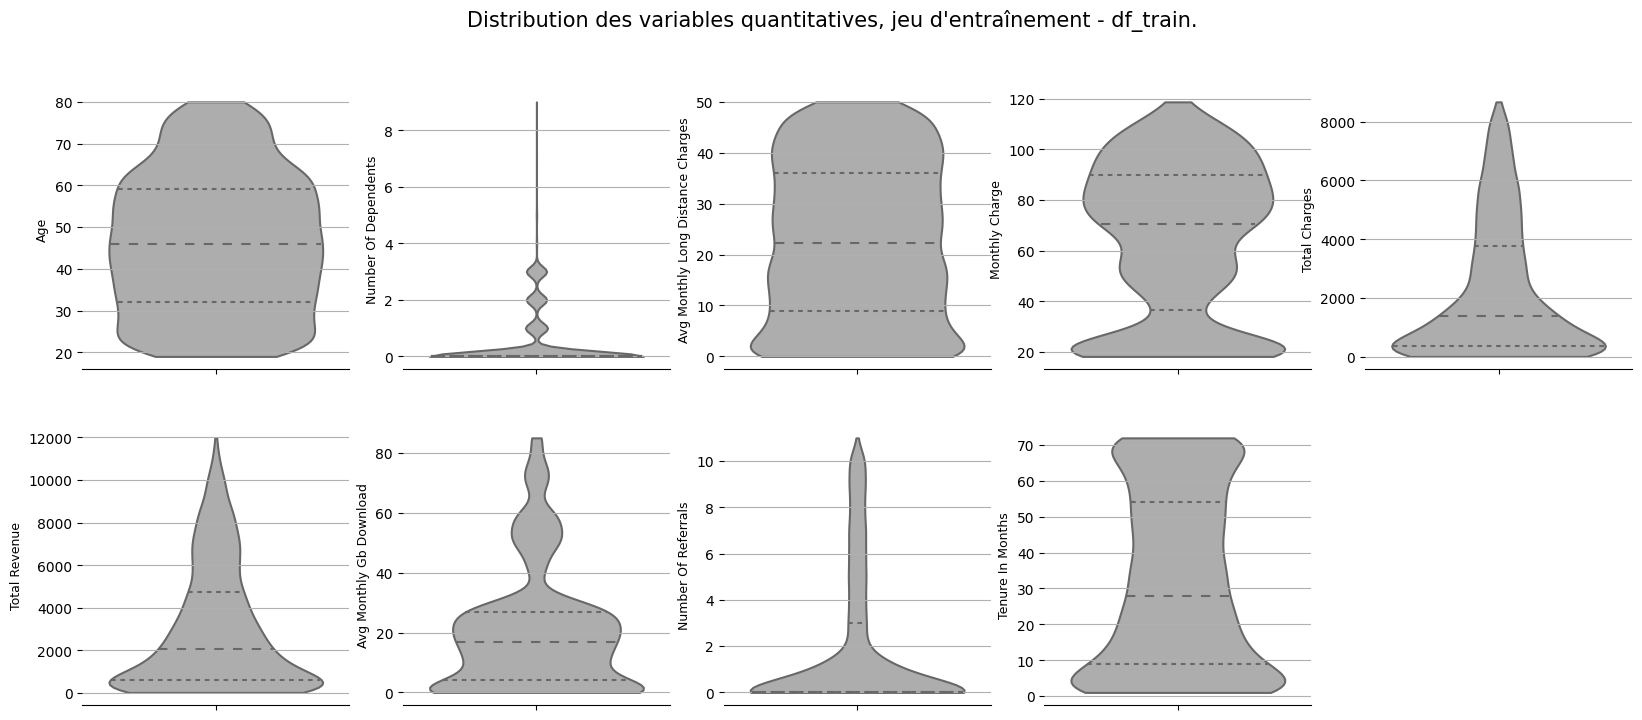

In [22]:
# Représentation graphique de la distribution des variables numériques sous la forme de violinplot
# note : Pour éviter de trop grandes disparités, les variables nommées 'total_XXX' ne sont pas représentées
# car elles dépendent de l'ancienneté de chaque client.

# Définition du nombre de colonnes, de lignes pour ce graphique
ncols = 5
cols_ = [elt for elt in num_cols if elt not in ["total_refunds", "total_extra_data_charges", "total_long_distance_charges"]]
nrows = (np.ceil(len(cols_)/ncols)).astype(int)

 # Création de la figure
fig, axes = plt.subplots(ncols= ncols, nrows = nrows, figsize=( 4*ncols, 4*nrows))
(i, j) = (0,0)

for var in cols_ :
   if j== ncols :  # on passe à la ligne
        j = 0
        i += 1
 
   # Création du boxplot
   sns.violinplot(ax=axes[i,j], data=df_train, y=var, 
                  color='#adadad', inner='quart', 
                  density_norm="count", cut=0)

   # Gestion des axis et labels
   axes[i,j].set_xlabel("")
   axes[i,j].set_ylabel(var.replace("_", " ").title(), fontsize=9)

   # Ajout des lignes horizontales
   axes[i,j].grid(visible=True, which='major', axis='y')
   axes[i,j].spines['top'].set_visible(False)
   axes[i,j].spines['right'].set_visible(False)
   axes[i,j].spines['bottom'].set_visible(True)
   axes[i,j].spines['left'].set_visible(False)
   j += 1

# Suppression des axes pour le dernier graphique qui est vide
if j<5 :
    axes[i,j].set_axis_off()

# Ajout du titre principal
fig.suptitle(f'Distribution des variables quantitatives, jeu d\'entraînement - df_train.',fontsize=15)
fig.show()

Globalement les variables quantitatives ne semblent pas présenter d'outlier.

Les clients répertoriés présentent les profils principaux suivants:
* un âge médian de 46 ans
* pas de personne à charge
* ils sont clients depuis en moyenne 32 mois, paient actuellement en moyenne 65 euros tout compris pour les différents services telecoms auxquels ils ont souscrits.
* Ils parrainent en moyenne 2 personnes
* et consomment en moyenne 20,7 Go de données sur leur mobile.


## 2.4 Cohérence entre variables

Dans cette section, nous investiguons un peu plus en détail la cohérence entre les différentes variables afin d'identifier les potentielles erreurs et de gagner en compréhension quant à la définition de certaines variables.

In [23]:
# Nous effectuons une copie de notre dataframe df_train
df_train_c = df_train.copy()

### 2.4.1 Variables socio-démographiques

Vérifions tout d'abord la cohérence entre les variables 'senior_citizen', 'age', 'under_30'

In [24]:
# Vérifions que si senior_citizen = Yes, l'age minimum soit 65 ans
df_train_c.loc[df_train_c["senior_citizen"]=="Yes","age"].min()

65

In [25]:
# Vérifions que si senior_citizen = No, l'age maximum soit < 65 ans
df_train_c.loc[df_train_c["senior_citizen"]=="No","age"].max()

64

In [26]:
# Vérifions que si under_30 = Yes, l'age maximum soit < 30ans
df_train_c.loc[df_train_c["under_30"]=="Yes","age"].max()

29

In [27]:
# Vérifions que si under_30 = No, l'age minimum soit 30 ans
df_train_c.loc[df_train_c["under_30"]=="No","age"].min()

30

Les variables '`age`' , '`senior_citizen`', '`under_30`' sont cohérentes.

Procédons de même pour les variables '`referred_a_friend`' et '`number_of_referrals`'.

In [28]:
# Vérifions que si referred_a_friend = Yes, le number_of_referrals minimum soit 1
df_train_c.loc[df_train_c["referred_a_friend"]=="Yes","number_of_referrals"].min()

1

In [29]:
# Vérifions que si referred_a_friend = No, le number_of_referrals = 0
df_train_c.loc[df_train_c["referred_a_friend"]=="No","number_of_referrals"].max()

0

Procédons de même pour les variables '`dependents`' et '`number_of_dependents`'.

In [30]:
# Vérifions que si dependents = Yes, le number_of_dependents minimum soit 1
df_train_c.loc[df_train_c["dependents"]=="Yes","number_of_dependents"].min()

1

In [31]:
# Vérifions que si dependents = No, le number_of_dependents = 0
df_train_c.loc[df_train_c["dependents"]=="No","number_of_dependents"].max()

0

Les variables '`dependents`' et '`number_of_dependents`' sont cohérentes.


### 2.4.2 Variables concernant les services additionnels

Procédons identiquement pour les variables '`internet_service`' et '`internet_type`'

In [32]:
# Vérifions que si internet_service = No, internet_type = None
df_train_c.loc[df_train_c["internet_service"]=="No","internet_type"].value_counts()

None    878
Name: internet_type, dtype: int64

In [33]:
# Vérifions que si internet_service = Yes, internet_type != None
df_train_c.loc[df_train_c["internet_service"]=="Yes","internet_type"].value_counts()

Fiber Optic    1801
DSL             967
Cable           480
Name: internet_type, dtype: int64

### 2.4.3 Variables concernant les charges

De la même manière, regardons si les variables suivantes sont cohérentes entre elles :
* '`avg_monthly_long_distance_charges`', '`total_long_distance_charges`'
* '`total_revenue`', '`total_charges`','`total_refunds`', '`total_extra_data_charges`', '`total_long_distance_charges`'
* '`total_charges`', '`monthly_charge`'


In [34]:
# Vérification que avg_monthly_long_distance_charges = total_long_distance_charges / tenure in month
(df_train_c["avg_monthly_long_distance_charges"] 
 - df_train_c["total_long_distance_charges"]/df_train_c["tenure_in_months"]).describe()

count    4.126000e+03
mean    -4.638935e-17
std      1.900520e-15
min     -7.105427e-15
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.105427e-15
dtype: float64

In [35]:
# Vérifions que total_revenue = total_charges - total_refunds + total_extra_data_charges 
#                                       + total_long_distance_charges
(df_train_c["total_revenue"] - 
  (df_train_c["total_charges"]-df_train_c["total_refunds"]
   +df_train_c["total_extra_data_charges"]
   +df_train_c["total_long_distance_charges"])).describe()

count    4.126000e+03
mean    -1.693696e-15
std      2.832239e-13
min     -1.818989e-12
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.818989e-12
dtype: float64

La variable '`monthly_charge`' représente les charges actuelles que paient les clients, cette variable n'étant pas une moyenne il est fort probable qu'elle ne soit pas égale au ratio de '`total_charges`' sur '`tenure_in_months`' : 

In [36]:
# Vérification que monthly_charge != total_charges / tenure_in_months
(df_train_c["monthly_charge"]-df_train_c["total_charges"]/df_train_c["tenure_in_months"]).describe()

count    4126.000000
mean        0.020711
std         2.668964
min       -17.125000
25%        -1.166429
50%         0.000000
75%         1.171745
max        19.125000
dtype: float64

Ces vérifications valident le fait que :
* `avg_monthly_long_distance_charges` = `total_long_distance_charges` / `tenure_in_months`
* `total_revenue` =  `total_charges` - `total_refunds` + `total_extra_data_charges` + `total_long_distance_charges`
* `monthly_charge` n'est pas égal à `total_charges` / `tenure_in_months`

### 2.4.4 Relation entre les offres et les différents services

On cherche à analyser si certains services sont déjà contenus dans les 5 types d'offres marketing proposées aux clients.

In [37]:
services = json_["additional services"]["bool"]
for var in  services : 
    print(f"\n{var}")
    print(round(pd.crosstab(df_train["offer"], df_train[var], normalize="index")*100,2))



device_protection_plan
device_protection_plan     No    Yes
offer                               
None                    66.39  33.61
Offer A                 34.22  65.78
Offer B                 54.72  45.28
Offer C                 63.95  36.05
Offer D                 77.32  22.68
Offer E                 84.71  15.29

phone_service
phone_service     No    Yes
offer                      
None            9.76  90.24
Offer A         8.31  91.69
Offer B         8.58  91.42
Offer C        11.63  88.37
Offer D         8.47  91.53
Offer E        11.89  88.11

multiple_lines
multiple_lines     No    Yes
offer                       
None            61.35  38.65
Offer A         30.23  69.77
Offer B         42.27  57.73
Offer C         54.26  45.74
Offer D         66.12  33.88
Offer E         79.41  20.59

internet_service
internet_service     No    Yes
offer                         
None              21.47  78.53
Offer A           17.61  82.39
Offer B           19.74  80.26
Offer C           19

Les différentes offres proposées n'incluent pas les services désignés par les variables '`device_protection_plan`', '`phone_service`', '`multiple_lines'`, '`internet_service`', '`online_security`', '`online_backup`', '`premium_tech_support`', '`unlimited_data`'.

## 2.5 Statistiques bivariées avec la variable cible

### 2.5.1 Liaison entre les variables quantitatives et la variable cible

Afin d'avoir un aperçu général des liaisons entre la target et les variables explicatives quantitatives nous créons pour chacune des variables des boxplots par distinction de cible.

/tmp/ipykernel_3822/2656052644.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


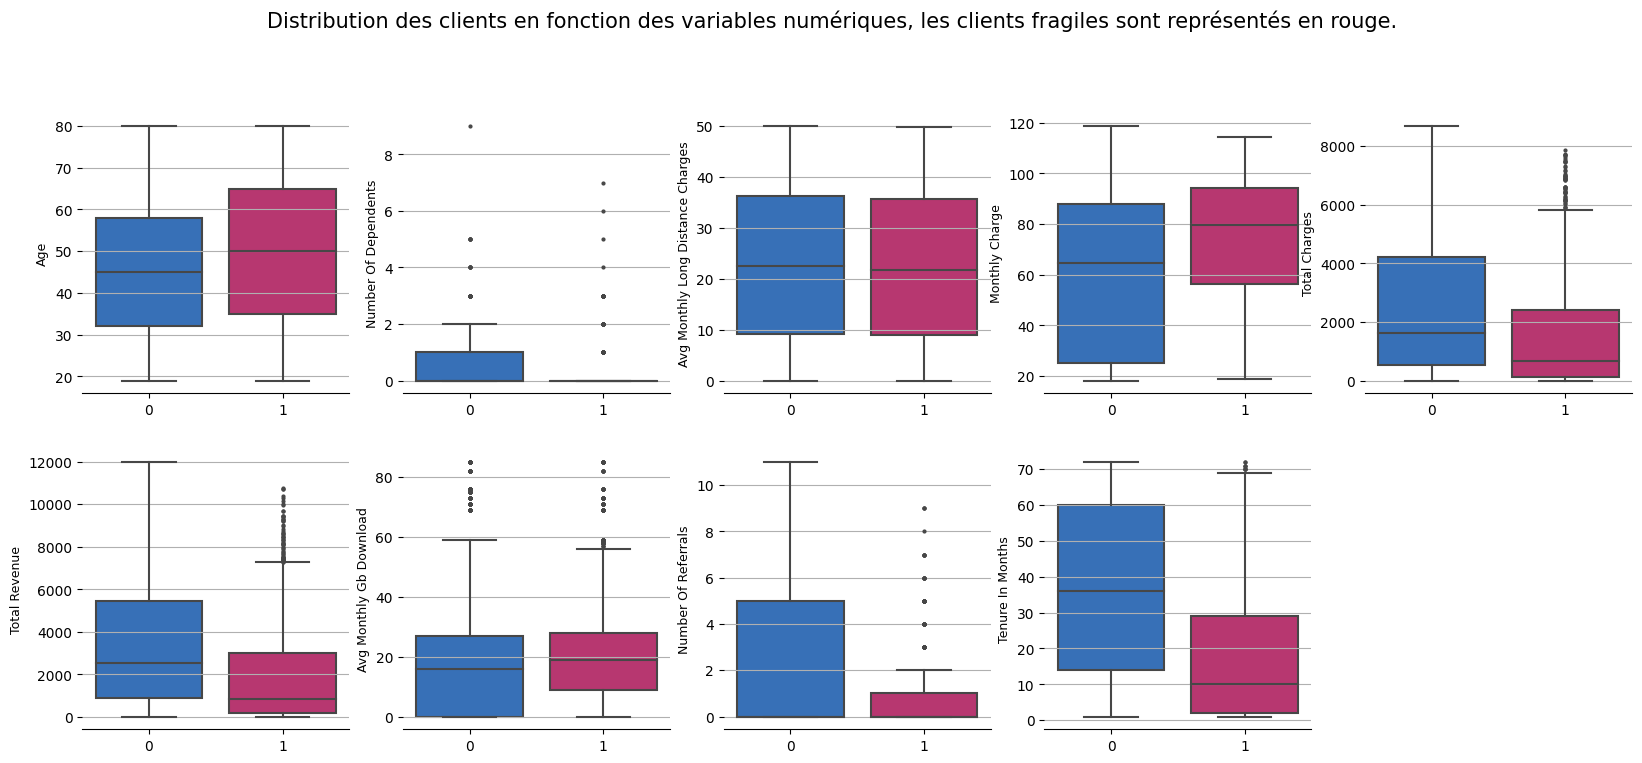

In [38]:
# Définition des variables numériques à représenter
num_cols_ = [elt for elt in num_cols if elt not in ["churn_value", "total_refunds", "total_extra_data_charges", "total_long_distance_charges"]]

# definition de ncols et rows
ncols = 5
nrows = (np.ceil(len(num_cols_)/ncols)).astype(int)
palette = {1: '#CC226E', 0: '#226ECC'}

# Création de la figure 
fig, ax = plt.subplots(ncols= ncols, nrows = nrows, figsize=(4*ncols, 4*nrows))

(i , j) = (0, 0)
for var in num_cols_ :
    if j == ncols :
        i += 1
        j = 0

    # Création du boxplot
    sns.boxplot(ax=ax[i,j], data=df_train, y=var, x="churn_value",
               width = 0.8, flierprops={"marker": ".", "markersize" : "4"} , palette = palette)

    # Gestion des axis et labels
    ax[i,j].set_xlabel('')
    ax[i,j].set_ylabel(var.replace("_", " ").title(), fontsize=9)

    # Ajout des lignes horizontales
    ax[i,j].grid(visible=True, which='major', axis='y')
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)
    ax[i,j].spines['bottom'].set_visible(True)
    ax[i,j].spines['left'].set_visible(False)
    j += 1

# Suppression de la grille pour le dernier ax
if j<5 :
    ax[i,j].set_axis_off() #

# Ajout du titre
fig.suptitle("Distribution des clients en fonction des variables numériques, les clients fragiles sont représentés en rouge.", fontsize=15,  y=1.01)
fig.show()

Il semble que les clients fragiles soient caractérisés :
- par un âge plus élevé (50 ans en valeur médiane contre 45 ans)
- ils n'ont pas d'enfant à charge
- ils sont clients depuis 10 mois en valeur médiane, tandis que les clients fidéllisés sont clients depuis plus 3 ans en valeur médiane.
- il paient des charges mensuelles beaucoup plus élevées (80 euros en valeur médiane contre 65 euros)
En résumé plus la clientèle est fidélisée sur le long terme et le plus bas est sa facture actuelle mensuelle, le moins elle semble être fragile.


### 2.5.2 Liaison entre les variables qualitatives et la variable cible

Afin d'avoir un aperçu général des liaisons entre la target et les variables explicatives catégorielles et booléennes nous créons pour chacune des variables des barplots par distinction de cible. 

Pour chaque variable, 2 barplots sont créés :
* celui de gauche représente le pourcentage de chaque catégorie déclinée selon l'indicateur '`churn_value`'
* tandis que sur celui de droite nous représentons le pourcentage des clients fragiles normalisé au sein de chaque catégorie.

/tmp/ipykernel_3822/2387237029.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


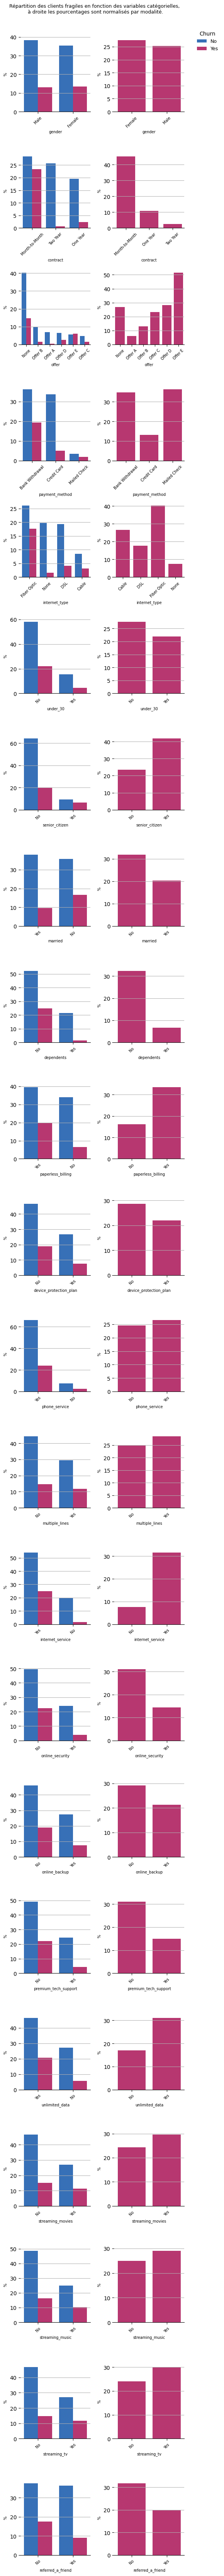

In [39]:
# Pour chaque variable booléenne et catégorielle : 
# --> Création de 2 barplots :
#      -> Gauche : pourcentage absolue de chaque catégorie déclinée selon l'indicateur churn_value 
#      -> Droite  : Le pourcentage des clients fragiles est normalisé au sein de chaque catégorie
bool_cols.remove("churn_value")
nrows = len(cat_cols + bool_cols) 

# Création de la figure
fig, ax = plt.subplots(ncols= 2, nrows = nrows, figsize=(  5, 3*nrows))
plt.subplots_adjust(hspace=0.6, wspace=0.6) # espace entre les axes

#Définition de la palette et de la légende
palette = ['#226ECC', '#CC226E']


# Pour chaque variable
for i, var in enumerate(cat_cols + bool_cols) :

    # Création du barplot des poucentages absolus de chaque  couple (catégorie-churn)
    df_plot = (np.round(df_train.value_counts(subset=[var,"churn_value"],normalize=True)*100,1)).reset_index()
    sns.barplot(ax=ax[i,0], y=df_plot[0], x=var, hue = "churn_value", data= df_plot , palette = palette)

    # Création du barplot des poucentages normalisés des clients fragiles pour chaque catégorie 
    df_plot = np.round((pd.crosstab(index=df_train[var], columns=df_train["churn_value"], normalize="index")*100),2)
    df_plot = df_plot[1].reset_index()
    df_plot.columns = [var, 'percentage_churn']
    sns.barplot(ax=ax[i,1], data = df_plot, x=var, y= 'percentage_churn', color = "#CC226E")

    ax[i, 0].get_legend().remove()
    #  Définition des axis et labels
    for ax1 in ax[i, :]:
        ax1.set_xlabel(var, fontsize=7)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize= 7)
        ax1.set_ylabel("%", fontsize=7)
    
        #  Ajout des lignes horizontales
        ax1.grid(visible=True, which="major", axis='y')
        ax1.spines['top'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.spines['right'].set_visible(False)

# Ajout de la légende à la figure
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, ['No', 'Yes'] , loc='upper right', bbox_to_anchor= (1.15, 1), borderaxespad=0, frameon=False, title = "Churn",fontsize=9)

# Ajouter du titre
fig.tight_layout()
fig.suptitle("Répartition des clients fragiles en fonction des variables catégorielles,\n à droite les pourcentages sont normalisés par modalité.", fontsize=9,  y=1.01)#  des véhicules en fonction du nombre de rapports \net du type de boîte de vitesses."
fig.show()

L’analyse de la répartition des clients fragiles en fonction des modalités des différentes variables catégorielles vient plussoyer ce que nous avons constaté dans la section précédente et nous permet d’affiner des tendances quant à leur profil. Parmi elles trouve une représentation significative de clients:
* n’ayant pas d’engagement en ayant souscrit à un contrat au mois
* ayant souscrit à un service internet - notamment la fibre optique
* célibataire, sans enfant à charge 
* seniors (> 65 ans)
* non engagé dans une démarche de parrainage.

Pour résumer les différents résultats issus de la section 2.5, il apparaît très clairement que les facteurs principaux influençant la fragilité des clients sont :
* leur fidélité et leur engagement : traduite par leur ancienneté, la démarche de parrainage et * * leur type d’engagement de contrat.
* leurs caractéristiques sociales : les personnes plus âgées, sans enfant à charge et célibataire sont plus enclines à résilier leur contrat
* leur souscription à un abonnement internet fixe
* et leur facture mensuelle (relativement plus élevée que celles des clients fidèles).


# 3. Préprocessing des données

## 3.1 Réduction préliminaire des variables

Comme nous l'avons vu précédemment (section 2.4), certaines variables numériques relatives aux charges payées par les clients sont calculées directement à partir d'autres variables, celles-ci peuvent donc être supprimées de notre modèle.

Les variables que nous avons choisies de supprimer de notre analyse sont les suivantes :
'`total_charges`','`total_long_distance_charges`','`total_revenue`'


In [40]:
# colonnes à supprimer
col_to_dels = ["total_charges","total_long_distance_charges","total_revenue"]
for i in col_to_dels : 
    num_cols.remove(i)

## 3.2 Suppression des variables à faible variance

Parmi les variables catégorielles et booléennes, aucune ne présente de modalité unique.

Regardons si les variables numériques dénombrent parmi elles des variables à faible variance (ie =< 0.3)

In [41]:
select_cstt = VarianceThreshold(threshold = 0.3)
num_col_cstt = select_cstt.fit(df_train[num_cols]).get_feature_names_out()
print(f"Sur les {len(num_cols)} variables quantitatives initiales, il y en a {len(num_col_cstt)} qui sont caractérisées par une variance > 0.3: \n{num_col_cstt}")

Sur les 9 variables quantitatives initiales, il y en a 9 qui sont caractérisées par une variance > 0.3: 
['age' 'number_of_dependents' 'avg_monthly_long_distance_charges'
 'monthly_charge' 'total_extra_data_charges' 'total_refunds'
 'avg_monthly_gb_download' 'number_of_referrals' 'tenure_in_months']


Notre base d'entraînement ne présente pas de variable à faible variance.

## 3.3 Discrétisation des variables numériques

Dans cette section, nous procédons à la discrétisation des variables quantitatives : 
* '`age`' :  ce qui permettra de nous affranchir des variables '`senior_citizen`' et '`under_30`'
* '`number_of_dependents`' 
* '`number_of_referrals`' 
* '`tenure_in_months`'
Cette stratégie a pour but de rendre notre modèle plus robuste.

In [42]:
# Permet la discrétisation d'une variable 'var' au sein d'un dataframe df, dans une plage d'intervalles (bins) 
# Renvoie : le dataframe avec la variable initiale + une nouvelle variable nommée var_bins
def discretization_variables (df : pd.DataFrame, var, bins : List) -> pd.DataFrame : 
    bins_ = [df[var].min()] + bins + [df[var].max()+1]
    df[var + "_bins"]=pd.cut(x = df[var],include_lowest = True,right = False,
                        bins = bins_, labels=False)
    return df


In [43]:
# Visualisation de la variable continue (var) sous la forme d'un density plot 
# et visualisation du résultat de sa discrétisation selon la plage d'intervalles bin
def plot_discretized_variable (df : pd.DataFrame, var, bin :List) :
    # Création de la figure
    fig, ax = plt.subplots(figsize=(6,4))

    # Définition des intervalles de discrétisation
    bins_ = [df[var].min()] + bin + [df[var].max()+1]
    
    # Density plot de la variable continue
    sns.kdeplot(ax = ax,data = df, x=var,  alpha=0.6, fill=True,  legend=False, cut= 0, color = "#CC226E")
    
    # Histogramme de la variable discrétisée
    ax2 = ax.twinx()
    sns.histplot(ax = ax2, data=df, x=var, bins=bins_,stat = "frequency", color="#226ECC")

    # Définition des axes
    ax.set_xlabel(f"{var}", fontsize=9)
    ax.set_ylabel('Distribution', fontsize=9)
    ax2.set_ylabel('')
    ax2.set_yticks([])

    # Ajout des lignes horizontales
    ax.grid(visible=True, which='major', axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['left'].set_visible(True)

    # Définition du titre du graphique
    ax.set_title(f"Distribution de la variable {var} continue et discrétisée - set d'entraînement", fontsize=10)
    
    fig.show()

### 3.3.1 Age

Comme nous l'avons vu précédemment, les 3 variables '`age`', '`under_30`' et '`senior_citizen`' sont cohérentes entre elles. Il est possible dans ce cas de figure de réduire ces 3 variables en 1 en conservant l'ensemble de leurs informations en discrétisant la variable numérique '`age`' de sorte à inclure les classes d'âge < 30 ans et > 65 ans.

Les classes d'intervalles que nous avons choisies sont les suivantes : 
*  âge < 30 ans
*  30 =< âge < 40 ans
*  40 =< âge < 50 ans
*  50 =< âge < 65 ans
*  âge >= 65 ans

/tmp/ipykernel_3822/156827668.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


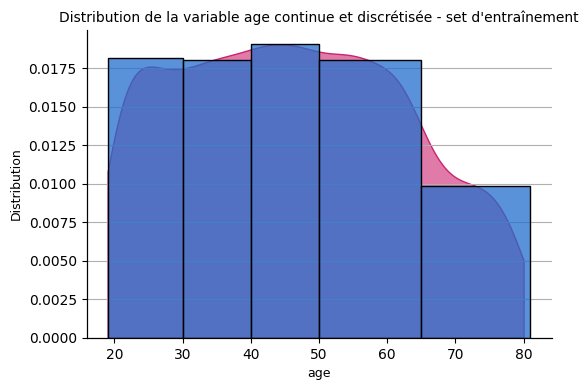

In [44]:
plot_discretized_variable(df_train, "age", [30,40,50,65])

In [45]:
# Discrétisation de la variable age
df_train = discretization_variables (df_train, 'age', [30,40,50,65])  

# Affichage des résultats
df_train[['age','age_bins']].sample(n=10, random_state=seed)



,age,age_bins
2007,20,0
401,74,4
1735,59,3
3744,30,1
59,75,4
4808,61,3
244,70,4
785,78,4
1549,23,0
5051,62,3


In [46]:
# Affichons la distribution de nos observations selon les modalités de la variable age_bins
round(df_train['age_bins'].value_counts(normalize=True)*100,2)

3    27.05
0    20.02
2    19.07
1    18.08
4    15.78
Name: age_bins, dtype: float64

Nous pouvons remarquer que les catégories d'âge définies ci-dessus sont relativement bien réparties, avec la classe dominante des 50-65 ans (labellisée 3) représentant 27.27% de nos observations.

Nous pouvons dès à présent supprimer les variables '`age`', '`senior_citizen`' et '`under_30`'

In [47]:
bool_cols.remove('senior_citizen')
bool_cols.remove('under_30')
num_cols.remove("age")

### 3.3.2 Taille de la famille

Les opérateurs dans leurs offres disposent généralement de pack multiservices télécoms ajustés à la taille de la familles.

Dans cette section nous allons créer une nouvelle variable '`family_size`' regroupant le client, le nombre de personnes dont il est à charge ainsi que son conjoint.

In [48]:
# Création de la variable family_size
df_train["family_size"] = df_train["number_of_dependents"] + 1 + df_train["married"].map({"Yes" : 1, "No": 0})

# Affichage des 5 1ères du dataframe
df_train[["family_size","number_of_dependents","married"]].sample(n=5)

,family_size,number_of_dependents,married
2768,1,0,No
708,3,1,Yes
3540,1,0,No
1121,1,0,No
1834,1,0,No


Pour des besoins métiers, selon les différents packs proposés par les différents opérateurs que nous avons relevés, nous nous proposons de discrétiser la variable '`family_size`' en 4 groupes :
* Les personnes vivant seules
* les familles composées de 2 personnes
* Les familles composées de 2 < personnes =< 4 
* Les familles composée de plus de 4 personnes.

/tmp/ipykernel_3822/156827668.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


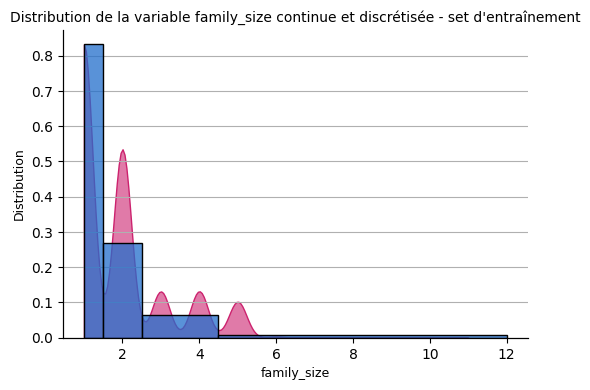

In [49]:
plot_discretized_variable(df_train, "family_size", [1.5,2.5,4.5])

In [50]:
# Discrétisation de la variable family_size
df_train = discretization_variables(df_train, "family_size", [1.5,2.5,4.5])

# Affichage des résultats
df_train[["family_size","family_size_bins"]].sample(n=10, random_state=seed)

,family_size,family_size_bins
2007,1,0
401,2,1
1735,1,0
3744,3,2
59,2,1
4808,4,2
244,2,1
785,1,0
1549,1,0
5051,1,0


In [51]:
# Affichons la distribution de nos observations selon les modalités de la variable family_size_bins
round(df_train['family_size_bins'].value_counts(normalize=True)*100,2)

0    47.87
1    30.76
2    15.15
3     6.23
Name: family_size_bins, dtype: float64

Il ne nous est plus nécessaire de conserver les variables '`dependents`' et '`number_of_dependents`' dont les informations sont reprises par notre nouvelle variable '`family_size_bins`'.

In [52]:
bool_cols.remove("dependents")
num_cols.remove("number_of_dependents")

### 3.3.3 Parrainage

De la même manière que précédemment nous choisissons de discrétiser le nombre de parrainages selon les classes d'intervalles suivantes : 
* nombre de parrainages  = 0
* nombre de parrainages = 1
* 2 <= nombre de parrainages <5
* Nombre de parrainages >= 5

/tmp/ipykernel_3822/156827668.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


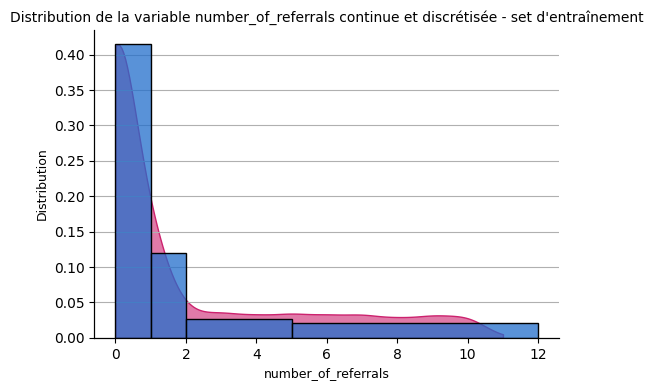

In [53]:
plot_discretized_variable(df_train, "number_of_referrals", [1,2,5])

In [54]:
# Discrétisation de la variable number_of_referrals
df_train = discretization_variables(df_train, "number_of_referrals", [1,2,5])

# Affichage des résultats
df_train[['number_of_referrals','number_of_referrals_bins']].sample(n=10, random_state=seed)

,number_of_referrals,number_of_referrals_bins
2007,0,0
401,7,3
1735,0,0
3744,7,3
59,1,1
4808,0,0
244,3,2
785,0,0
1549,0,0
5051,0,0


In [55]:
# Affichons la distributions de nos observations selon les modalités de la variable number_of_referrals_bins
round(df_train['number_of_referrals_bins'].value_counts(normalize=True)*100,2)

0    54.73
3    19.24
1    15.73
2    10.30
Name: number_of_referrals_bins, dtype: float64

Nous supprimons les variables '`referred_a_friend`' et '`number_of_referrals`' pour la suite de l'étude.

In [56]:
bool_cols.remove('referred_a_friend')
num_cols.remove('number_of_referrals')

### 3.3.4 Ancienneté des clients

Comme nous l'avons vu précédemment (dans la section 2.5), l'ancienneté du client (ie la variable '`tenure_in_months`'), possède une forte liaison avec la variable cible, de sorte qu'un nouveau client sera plus propice à résilier son contrat. Nous choisissons de discrétiser cette variable en nous basant sur des intervalles de 1 an, avec une descente en échelle de 6 mois pour la première année.  

/tmp/ipykernel_3822/156827668.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


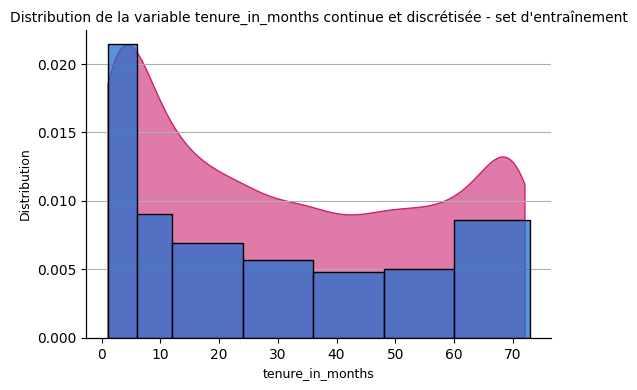

In [57]:
plot_discretized_variable(df_train, "tenure_in_months", [6,12,24,36,48,60])

In [58]:
# Discrétisation de la variable tenure_in_months
df_train = discretization_variables(df_train, "tenure_in_months", [6,12,24,36,48,60])

# Affichage des résultats
df_train[['tenure_in_months','tenure_in_months_bins']].sample(n=10, random_state=seed)

,tenure_in_months,tenure_in_months_bins
2007,36,4
401,66,6
1735,1,0
3744,42,4
59,34,3
4808,23,2
244,24,3
785,35,3
1549,18,2
5051,19,2


In [59]:
# Affichons la distributions de nos observations selon les modalités de la variable tenure_in_months_bins
round(df_train['tenure_in_months_bins'].value_counts(normalize=True)*100,2)

6    20.58
0    19.73
2    15.29
3    12.60
5    11.17
4    10.62
1    10.01
Name: tenure_in_months_bins, dtype: float64

Nous supprimons la variable '`tenure_in_months`' pour la suite de l'étude.

In [60]:
num_cols.remove("tenure_in_months")

## 3.4 Feature engineering 

### 3.4.1 Nombre de services

Les clients de notre entreprise dont la possibilité de souscrire à plusieurs options de services. Nous disposons pour chaque observation de ces renseignements par le biais de 8 booléennes. 

Il est envisageable de considérer que la fragilité d'un client peut être mise en relief par le nombre d'options supplémentaires auxquelles il a adhéré. Nous choisissons par conséquent de créer une nouvelle variable '`total_of_services_add`' permettant de stocker cette information. 

Au cours de l'étape de la présélection des variables explicatives, nous jugerons de la pertinence de cette nouvelle variable.

In [61]:
# On compte le nombre de services et on stocke le résultat dans la variable total_of_services_add
df_train["total_of_services_add"] = (df_train[services]=="Yes").sum(axis =1)

# Affichage des résultats
df_train[services + ["total_of_services_add"]].head()


,device_protection_plan,phone_service,multiple_lines,internet_service,online_security,online_backup,premium_tech_support,unlimited_data,total_of_services_add
4706,No,Yes,Yes,Yes,No,No,No,No,3
4116,No,Yes,No,No,No,No,No,No,1
1665,No,Yes,Yes,Yes,No,Yes,No,Yes,5
99,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,7
1468,No,Yes,No,Yes,No,No,No,No,2


In [62]:
# Affichage des principaux indicateurs statistiques de la variable total_of_services_add
df_train["total_of_services_add"].describe()

count    4126.000000
mean        4.033931
std         2.014448
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         8.000000
Name: total_of_services_add, dtype: float64

Nous pouvons observer qu'en moyenne les clients ont opté pour 4 services supplémentaires.

### 3.4.2 Les charges

Nous pouvons estimer qu'une cause potentielle de fragilité d'un client peut être liée à l'augmentation de sa facture mensuelle. 

Pour ce faire, nous calculons le ratio entre les charges mensuelles actuelles et la moyenne mensuelle des charges payées depuis la subscription du client. Nous pouvons ensuite créer un indicateur booléen '`increased_monthly_charge`' qui vaut 1 si le ratio est supérieur à 1 et 0 si le ratio est =< 1.

In [63]:
# Calcule le ratio entre la charge mensuelle actuelle et la moyenne des charge mensuelles depuis le début de la souscription d'un client
# si le ratio >1 -> increased_monthly_charge = 1, increased_monthly_charge = 0 sinon
# Retourne le dataframe incluant la nouvelle variable increased_monthly_charge
def has_increased_monthly_charges (df ) :
    df_ = df.copy()
    df_["ratio_monthly_charge"] = df_["monthly_charge"]/(df_["total_charges"]/df_["tenure_in_months"])
    df_["increased_monthly_charge"] = df_["ratio_monthly_charge"].apply(lambda x : 0 if x<=1 else 1)
    print(df_[["ratio_monthly_charge","increased_monthly_charge"]].head())
    df_.drop(columns = "ratio_monthly_charge", inplace =True)
    return df_

In [64]:
# Création de la nouvelle variable increased_monthly_charge
df_train = has_increased_monthly_charges (df_train )
bool_cols.append("increased_monthly_charge")


      ratio_monthly_charge  increased_monthly_charge
4706              1.016869                         1
4116              1.251456                         1
1665              0.990160                         0
99                1.022055                         1
1468              1.000000                         0


Nous incluons également une nouvelle variable quantifiant le ratio entre total des charges supplémentaires et les charges totales qui peut être pertinente à analyser dans la suite de notre étude. 

Nous évaluerons au cours de la présélection des variables la pertinence des deux nouveaux indicateurs '`increased_monthly_charge`' et '`ratio_extra_charge`'.

In [65]:
# Création de la nouvelle variable ratio_extra_charge
df_train["ratio_extra_charge"] = df_train["total_extra_data_charges"]/df_train["total_charges"]
print(df_train["ratio_extra_charge"].describe())
num_cols.append("ratio_extra_charge")

count    4126.000000
mean        0.009212
std         0.078188
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.834008
Name: ratio_extra_charge, dtype: float64


In [66]:
# Nous définissons une liste stockant les variables numériques discrétisées
# Note : ces variables sont des variables catégorielles numériques.
cat_num_cols = ["age_bins", "family_size_bins", "number_of_referrals_bins","total_of_services_add",	"tenure_in_months_bins"]

# 4. Présélection des variables

Dans la section précédente, nous avons déjà procédé à l'élimination de variables redondantes. Nous continuons notre démarche de présélection des variables explicatives en effectuant :
* Dans une premier temps un filtre univarié 
* Pour ensuite effectuer une réduction du nombre de variables à l'intersection des résultats issus des méthodes RFE et Boruta.

## 4.1 Approche univariée

### 4.1.1 Variables catégorielles - V de Cramer

Dans cette section, nous étudions:
* d'une part les liaisons entre variables catégorielles explicatives afin d'éliminer les éventuelles variables redondantes 
* d'autre part la liaison de chacune des variables explicatives avec la variable cible. Nous retiendrons pour ce faire les variables explicatives ayant un coefficient de Cramer >= 0.09 avec la target.

In [67]:
# calcul V de Cramer pour deux variables
def cramer_v_coeff(x: List, y: List) -> float:
    """Cette fonction permet de calculer le V de
    Cramer entre deux varaibles catégorielles.

    Args:
        x : Le vecteur de variable x.
        y : Le vecteur de variable y.

    Returns:
        float: La valeur V de cramer.
    """
    # Suppression des NAs
    complete_cases = x.isna()*y.isna()
    x = x[~complete_cases]
    y = y[~complete_cases]

    # Calcul du Khi-deux max (dénomimateur du V de Cramer)
    n = len(x)
    khi2_max = n * min(len(x.value_counts()), len(y.value_counts())) - 1

    # Calcul du khi-deux (numérateur du V de Cramer)
    conf_matrix = pd.crosstab(x, y)
    khi2 = ss.chi2_contingency(observed=conf_matrix, correction=True)

    # Calcul V de Cramer et récupération p_value associée
    cramer = round(np.sqrt(khi2[0] / khi2_max), 4)
    p_value = khi2[1]

    return cramer, p_value


# calcul V de Cramer pour un dataframe
def compute_cramer_v(data: pd.DataFrame) -> pd.DataFrame:
        """Calculer le V de cramer pour un dataframe.

        Args:
            data: Jeu de données sur lequel on souhaite
            calculer le V de Cramer.

        Returns:
            DataFrame contenant les différents V de Cramer.
        """
        ncols = data.shape[1]
        cols = data.columns
        cramer_matrix = np.eye(ncols)
        for j in range(ncols - 1):
            for i in range(j + 1, ncols):
                cramer_matrix[[i, j], [j, i]] = cramer_v_coeff(
                    x=data.iloc[:, j],
                    y=data.iloc[:, i]
                )[0]
        cramer_matrix = pd.DataFrame(cramer_matrix, columns=cols, index=cols)
        return cramer_matrix

In [68]:
# fonction pour visualiser une matrice de liaison
def plot_heatmap_cor (cor_matrix, size = (15,15)):
    # Visualisation de la matrice de V de cramer_matrix
    mask = np.triu(np.ones_like(cor_matrix))
    fig, ax = plt.subplots(figsize = size)
    sns.heatmap(cor_matrix, annot=True, fmt=".2f", mask= mask, vmax=1, vmin=0, center=0.5) 
    ax.set(xlabel="", ylabel="")

In [69]:
# Calculons la matrice de Cramer pour les variables catégorielles et booléennes
cramer_matrix = compute_cramer_v(df_train[cat_cols + cat_num_cols + bool_cols + ["churn_value"]])

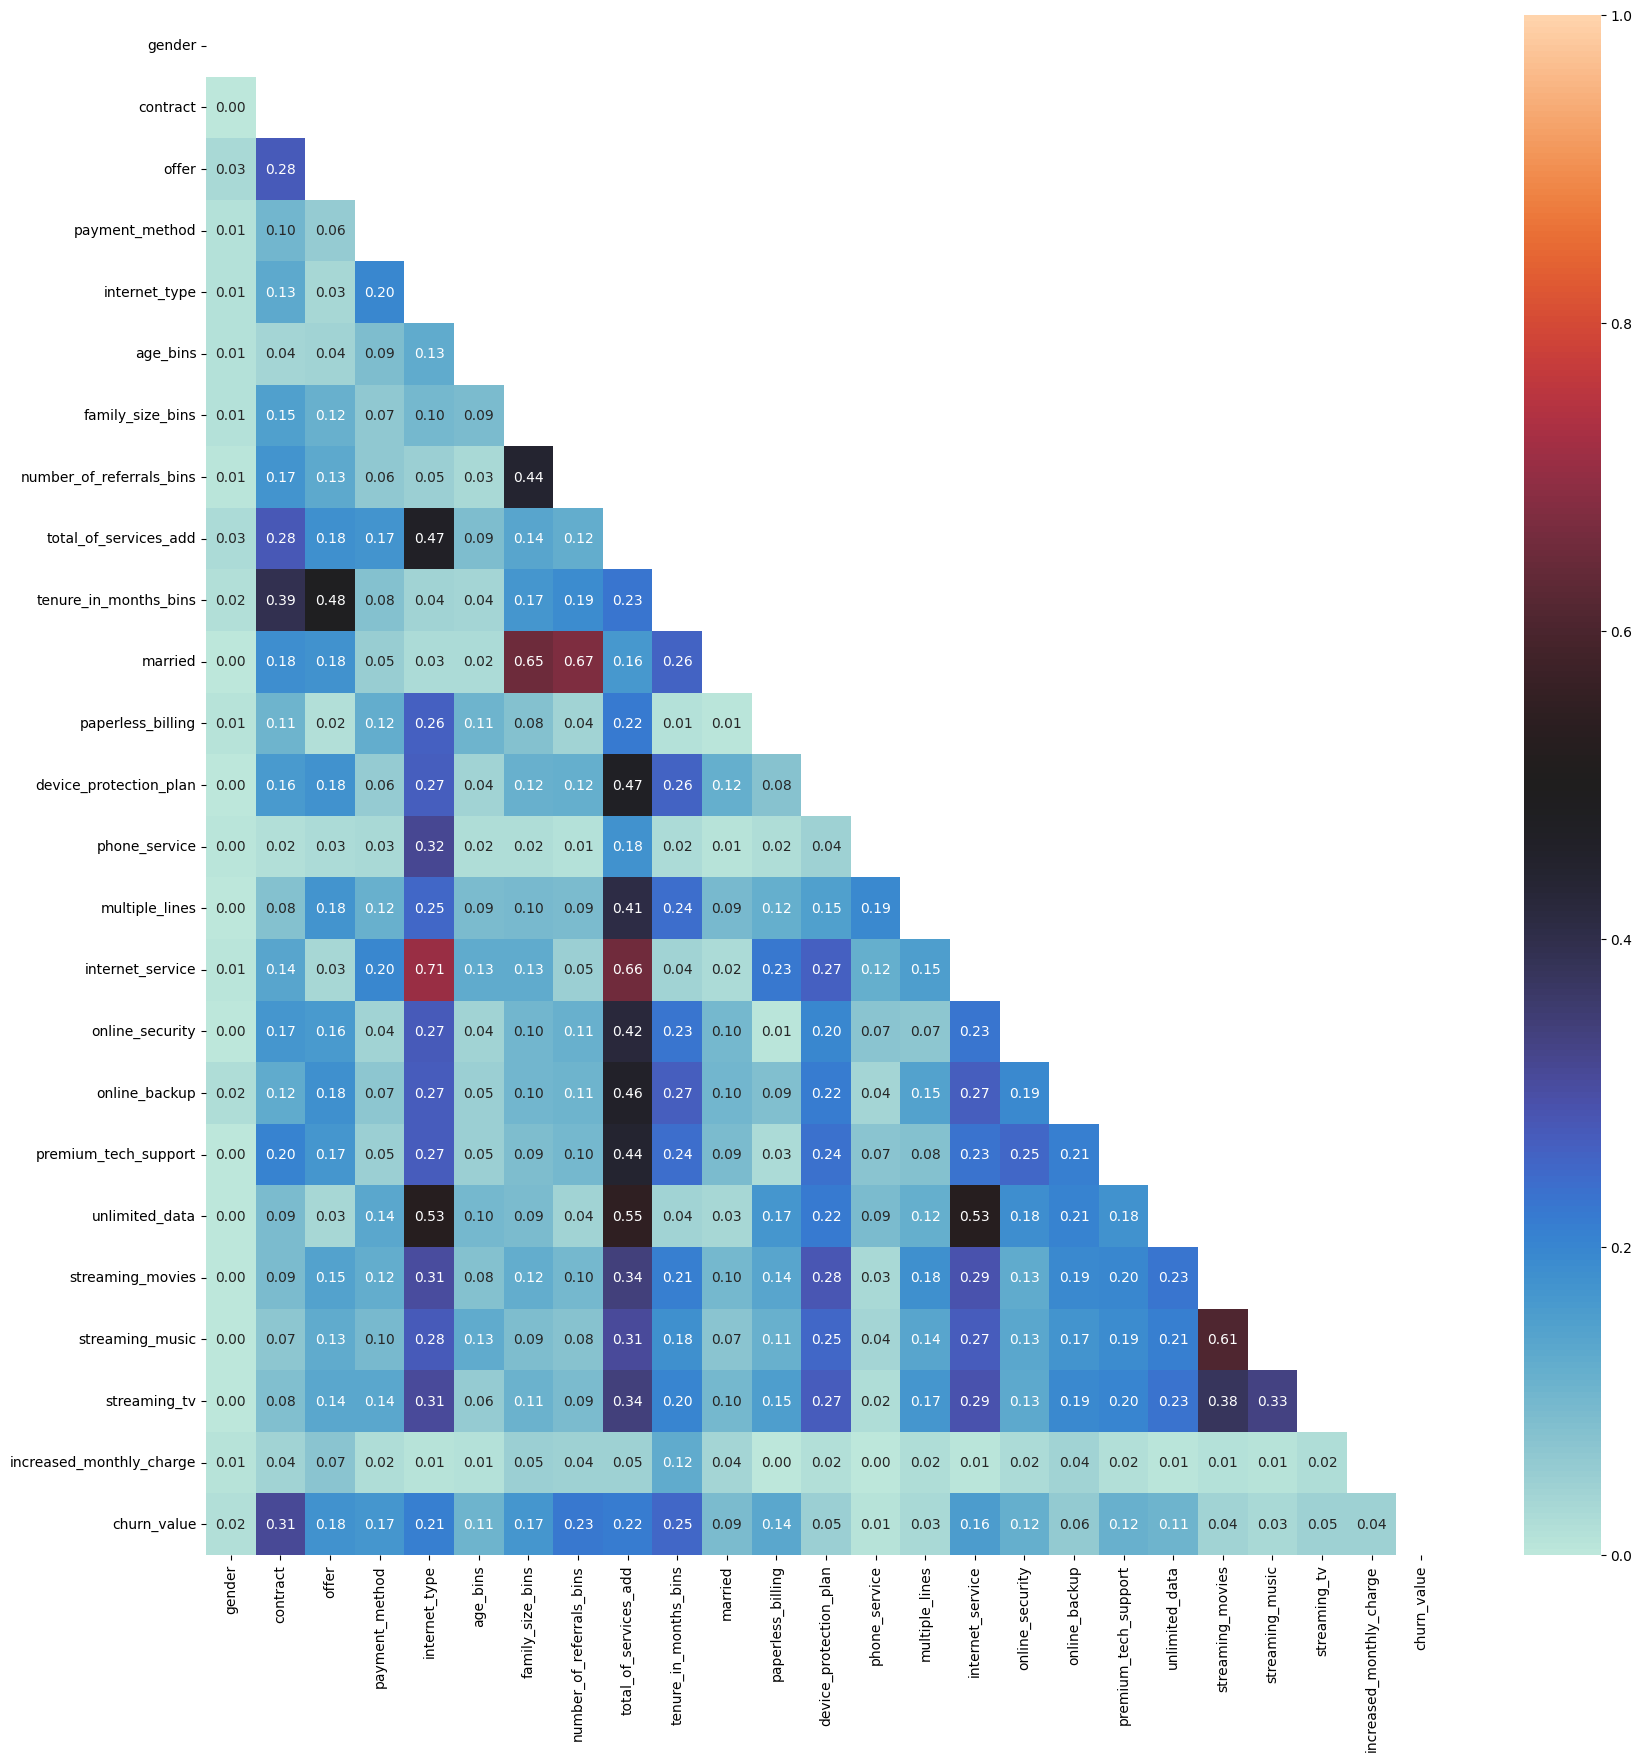

In [70]:
# Visualisation de la matrice de V de cramer_matrix
plot_heatmap_cor (cramer_matrix, size = (20,20))

Le graphique ci-dessus indique que les liaisons entre variables explicatives sont majoritairement relativement faibles (<= 0.50), nous pouvons néanmoins relever que :
* La variable '`married`' est relativement corrélée avec '`family_size_bins`' (0.65) et '`number_of_referrals_bins`' (0.67) mais sans redondance d'information
* La variable '`internet_service`' est relativement corrélée avec '`internet_type`' (0.71) et '`total_of_services_add`' (0.66)
* Les variables '`streaming_music`' et '`streaming_movie`' ont une liaison de Cramer de 0.61.
Néanmoins nous pouvons noter que ces indicateurs ont plutôt tendance à se compléter.

Regardons maintenant les liaisons entre variables explicatives et la variable cible '`churn_value`'

In [71]:
cramer_test = []
# On évalue de coefficient de Cramer et critère de significativité pour chaque couple variable - cible
for i,var in enumerate(cat_cols + cat_num_cols + bool_cols) : 
    cramer_results  =  cramer_v_coeff(x=df_train.loc[:,var],
                    y=df_train.loc[:,"churn_value"])
    cramer_test.append(
        {
            'features' : var,
            'cramer_v' : np.round(cramer_results[0],2),
            'p-value' : np.round(cramer_results[1],2)
        })
    
# Stockage des résultats pour chaque variable dans un dataframe
df_v_cramer = pd.DataFrame(cramer_test)

# Affichage des résultats
df_v_cramer.sort_values(by='cramer_v', ascending=False)

,features,cramer_v,p-value
1,contract,0.31,0.00
9,tenure_in_months_bins,0.25,0.00
7,number_of_referrals_bins,0.23,0.00
8,total_of_services_add,0.22,0.00
4,internet_type,0.21,0.00
2,offer,0.18,0.00
3,payment_method,0.17,0.00
6,family_size_bins,0.17,0.00
15,internet_service,0.16,0.00
11,paperless_billing,0.14,0.00


Ces résultats indiquent qu'il n'existe pas de corrélation aberrante entre variables explicatives et target, celles-ci ne dépassant pas 0.31.

9 variables sont caractérisées par un seuil de liaison minimale inférieur à 0.09 :
 * '`device_protection_plan`' 
 * '`online_backup`'  
 * '`streaming_movies`' 
 * '`streaming_tv`' 
 * '`increased_monthly_charge`'
 * '`streaming_music`' 
 * '`multiple_lines`' 
 * '`gender`' 
 * '`phone_service`' 

Remarquons à titre indicatif l'augmentation des factures mensuelles ('`increased_monthly_charge`') possède une liaison faible avec la cible.

Nous choisissons de supprimer ces 9 variables.

In [72]:
for var in df_v_cramer.loc[df_v_cramer["cramer_v"]<0.09,"features"].values : 
    if var in cat_cols :
        cat_cols.remove(var)
    else : 
        bool_cols.remove(var)

### 4.1.2 Variables numériques - Liaison de Pearson

In [73]:
# Calcul des corrélations de Pearson
df_pearson = df_train[num_cols + ["churn_value"]].corr()

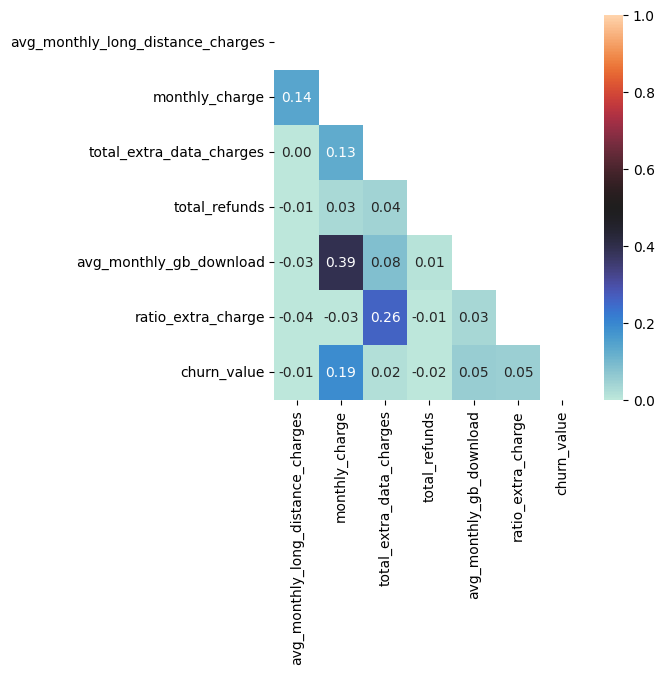

In [74]:
# Visualisation de la matrice de Pearson
plot_heatmap_cor (df_pearson, size = (5,5))


Les coefficients de corrélation de Pearson sont globalement relativement bas entre variables explicatives quantitatives, n'excédant pas 0.39 en valeur absolue.  

In [75]:
# Construire un dataframe contenant à la fois les coefficients
# de Pearson ( + leur valeur absolue) et la p-value associés à chaque variable quantitative
pearson_matrix = []
for col in num_cols :
    pearson_values =ss.pearsonr(x=df_train[col], y=df_train["churn_value"])
    pearson_matrix.append(
        {
            'features': col,
            'coef_pearson': round(pearson_values[0],3),
            'abs_coef_pearson': round(abs(pearson_values[0]),3),
            'p_value':  round(pearson_values[1],4)
        }
    )

# Stockage des résultats pour chaque variable dans un dataframe
pearson_matrix = (pd.DataFrame(pearson_matrix)
                 .sort_values(["coef_pearson"])
                 .reset_index(drop=True)
                )

# Affichage des résultats
pearson_matrix.sort_values(by = "abs_coef_pearson", ascending = False)

,features,coef_pearson,abs_coef_pearson,p_value
5,monthly_charge,0.190,0.190,0.0000
4,avg_monthly_gb_download,0.052,0.052,0.0008
3,ratio_extra_charge,0.048,0.048,0.0019
0,total_refunds,-0.025,0.025,0.1106
2,total_extra_data_charges,0.017,0.017,0.2653
1,avg_monthly_long_distance_charges,-0.008,0.008,0.5898


En considérant un coefficient de corrélation de Pearson >= 0.09 avec la variable cible, seule la variable '`monthly_charge`' est à conserver. Nous pouvons éliminer 5 variables numériques de notre analyse, à savoir : 
* '`avg_monthly_gb_download`'
* '`ratio_extra_charge`'
* '`total_refunds`'
* '`total_extra_data_charges`'
* '`avg_monthly_long_distance_charges`'

Notons que 3 d'entre elles présentent également un critère de significativité très largement supérieur à 0.05.


In [76]:
# Supprimons ces 5 variables numériques
for var in pearson_matrix.loc[pearson_matrix["abs_coef_pearson"]<0.09,"features"].values : 
    num_cols.remove(var)


## 4.2 Approche multivariée

In [77]:
# Séparation des features explicatives de la target en X_train et y_train
X_train = df_train[bool_cols + cat_cols + cat_num_cols + num_cols]
y_train = df_train["churn_value"]

In [78]:
print(f"A l'issue du tri univarié, il reste {X_train.shape[1]} variables explicatives :\n{X_train.columns.tolist()}")

A l'issue du tri univarié, il reste 16 variables explicatives :
['married', 'paperless_billing', 'internet_service', 'online_security', 'premium_tech_support', 'unlimited_data', 'contract', 'offer', 'payment_method', 'internet_type', 'age_bins', 'family_size_bins', 'number_of_referrals_bins', 'total_of_services_add', 'tenure_in_months_bins', 'monthly_charge']


### 4.2.1 Preprocessing pour préselection des variables

Afin de procéder à la présélection des variables explicatives suivant 2 techniques d'approche multivariée, nous préprocessons nos variables selon les étapes suivantes :
* encodage manuelle des variables booléennes ("No"--> 0, "Yes" --> 1)
* encodage one-hot avec pg_dummies des variables catégorielles textuelles
* Normalisation des variables quantitatives

In [79]:
# On crée une copie de X_train
X_train_c = X_train.copy()

# Encodage manuel des variables booléennes
X_train_c[bool_cols] = X_train_c[bool_cols].apply(
    lambda x : x.map({"Yes" : 1, "No" : 0}))

# Encodage one-hot des variables catégorielles textuelles
ord_cat = ['contract','offer', 'payment_method', 'internet_type']
X_train_dummies = pd.get_dummies(X_train_c,  prefix_sep='__',  columns=cat_cols)

# Normalisation des variables numériques
rs = StandardScaler()
X_train_dummies[num_cols] = rs.fit_transform(X_train_dummies[num_cols])


In [80]:
# Affichage des dimensions de X_train_dummies: 
print(f"Le dataframe préprocessé contient {X_train_dummies.shape[1]} colonnes")

# Affichage du dataframe X_train_dummies : 
X_train_dummies.head()

Le dataframe préprocessé contient 28 colonnes


,married,paperless_billing,internet_service,online_security,premium_tech_support,unlimited_data,age_bins,family_size_bins,number_of_referrals_bins,total_of_services_add,tenure_in_months_bins,monthly_charge,contract__Month-to-Month,contract__One Year,contract__Two Year,offer__None,offer__Offer A,offer__Offer B,offer__Offer C,offer__Offer D,offer__Offer E,payment_method__Bank Withdrawal,payment_method__Credit Card,payment_method__Mailed Check,internet_type__Cable,internet_type__DSL,internet_type__Fiber Optic,internet_type__None
4706,0,1,1,0,0,0,3,1,0,3,3,-0.512676,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4116,1,0,0,0,0,0,3,3,3,1,1,-1.507766,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1665,0,1,1,0,0,1,2,0,0,5,1,0.539181,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
99,1,1,1,0,1,1,4,1,1,7,6,1.454129,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
1468,0,0,1,0,0,0,3,0,0,2,0,0.490762,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0


### 4.2.2 Recursive Feature Elimination

Afin de sélectionner les variables explicatives les plus importantes, nous utilisons la méthode RFE avec cross validation (5 échantillons) en utilisant une forêt aléatoire pour classifieur.

In [81]:
# Définition du sélecteur RFECV, on définit un minimum de 8 variables à sélectionner
rfe_selector = RFECV(RandomForestClassifier(random_state=seed), 
                      step=1, min_features_to_select=8, cv=5, 
                      scoring='roc_auc', verbose=0, n_jobs=-1)

# entraînement du sélecteur
rfe_selector.fit(X_train_dummies, y_train)

# On récupère les features sélectionnées par la RFE
rfe_features = X_train_dummies.loc[:,rfe_selector.support_].columns.tolist()
print(f"RFE : {len(rfe_features)} variables sélectionnées sur {X_train_dummies.shape[1]} : \n{rfe_features}")

RFE : 13 variables sélectionnées sur 28 : 
['paperless_billing', 'online_security', 'age_bins', 'family_size_bins', 'number_of_referrals_bins', 'total_of_services_add', 'tenure_in_months_bins', 'monthly_charge', 'contract__Month-to-Month', 'contract__Two Year', 'offer__None', 'payment_method__Credit Card', 'internet_type__Fiber Optic']


Regardons l'évolution du score moyen AUC en fonction du nombre de variables durant les itérations de la RFE :

/tmp/ipykernel_3822/660675162.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


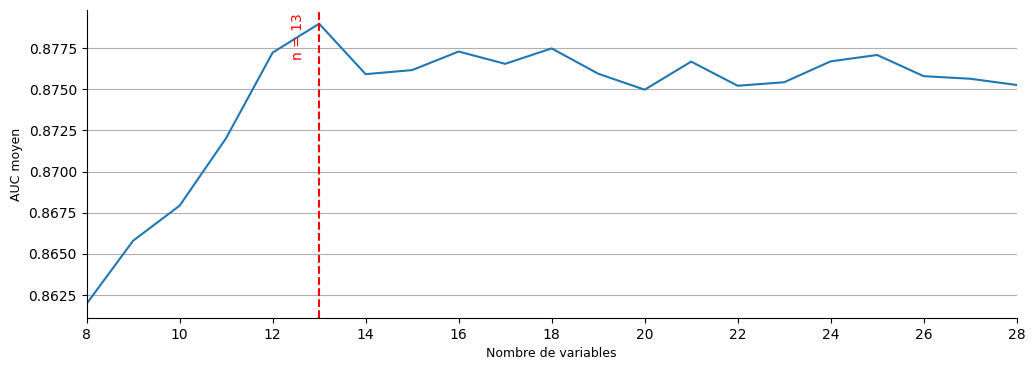

In [82]:
# On génère un dataframe contenant les scores en fonction du nombre de features sélectionnées
df_rfe = pd.DataFrame (data = {
    'nb_features' : range(8,X_train_dummies.shape[1]+1),
    'mean_AUC' : rfe_selector.cv_results_["mean_test_score"]
    })

# Création du graphique de l'AUC moyen en fonction du nombre de features
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=df_rfe, x="nb_features", y="mean_AUC")

# Ajout de la ligne verticale rouge pour n = 13
ax.axvline(x=len(rfe_features),  color='red', linestyle='--')
ax.text( 12.7,  0.99, f"n = {len(rfe_features)}", color='r', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
# Définition des axes
ax.set_xlabel(f"Nombre de variables", fontsize=9)
ax.set_xlim(8,28)
xticks = range(8, 29, 2)  # Intervalles de 2, par exemple
ax.set_xticks(xticks)
ax.set_ylabel('AUC moyen', fontsize=9)

# Ajout des lignes horizontales
ax.grid(visible=True, which='major', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
fig.show()


Nous pouvons remarquer que le choix optimum de 13 features valide également le principe de parcimonie, la courbe s'infléchissant pour n > 13.

Parmi ces 13 features, certaines résultent de l'encodage one-hot de variables 'racines', nous avons considéré dans ce qui suit que si une variable issue de l'encodage one-hot est retenue alors on sélectionne la variable racine :

In [83]:
# Permet de récupérer la liste des variables racines dont sont issues les features : 
# one_hot_encoder_features
def get_features_names (one_hot_encoder_features) : 
    features_filter = []
    for var in one_hot_encoder_features : 
        search_col = re.search(f"(.+)__", var)
        if search_col :
            features_filter.append(search_col.group(1))
        else :
            features_filter.append(var)
    return np.unique(features_filter).tolist()

# Récupération des noms des variables avant encodage : 
rfe_features_ = get_features_names(rfe_features)
print(f"Après processing des variables encodées selon un one-hot-encoder, {len(rfe_features_)} features sur {X_train_c.shape[1]} sont retenues: \n{rfe_features_}")

Après processing des variables encodées selon un one-hot-encoder, 12 features sur 16 sont retenues: 
['age_bins', 'contract', 'family_size_bins', 'internet_type', 'monthly_charge', 'number_of_referrals_bins', 'offer', 'online_security', 'paperless_billing', 'payment_method', 'tenure_in_months_bins', 'total_of_services_add']


Seules les 4 variables '`internet_service`', '`married`', '`premium_tech_support`', '`unlimited_data`' n'ont pas été retenues par la RFE.


### 4.2.3 Boruta

Dans cette section, nous utilisons la technique de préselection des variables de Boruta, nous ne conserverons ensuite que les variables explicatives validées par la RFE et la méthode Burota.

In [84]:
# Instanciation de la méthode Boruta utilisant une forêt aléatoire comme classifieur
boruta_selector  = BorutaPy(RandomForestClassifier(random_state = seed, max_depth = 4), n_estimators='auto',  verbose = 0)

# Entraînement du classifieur
boruta_selector.fit(X_train_dummies.values, y_train.values.ravel())

# On récupère les variables explicatives dont le rang est égal à 1 :
boruta_features = X_train_dummies.loc[:,boruta_selector.ranking_ == 1].columns.tolist()
boruta_features = get_features_names(boruta_features)
    
print(f"Boruta : {len(boruta_features)} variables sélectionnées sur {X_train_c.shape[1]} : \n{boruta_features}")

Boruta : 15 variables sélectionnées sur 16 : 
['age_bins', 'contract', 'family_size_bins', 'internet_service', 'internet_type', 'monthly_charge', 'number_of_referrals_bins', 'offer', 'online_security', 'paperless_billing', 'payment_method', 'premium_tech_support', 'tenure_in_months_bins', 'total_of_services_add', 'unlimited_data']


La méthode Boruta retient 3 variables de plus que la RFE : seule la variable '`married`' n'est pas sélectionnée. 

Nous choisissons pour la construction de notre modèle d'utiliser la liste des 12 variables explicatives définies par la RFE à savoir :
 * 1 variable numérique : 
 * * '`monthly_charge`'
 * 5 variables catégorielles ordinales : 
 * * '`age_bins`'
 * * '`family_size_bins`'
 * * '`number_of_referrals_bins`'
 * * '`tenure_in_months_bins`'
 * * '`total_of_services_add`'
 * 4 variables catégorielles textuelles: 
 * * '`contract`'
 * * '`internet_type`'
 * * '`offer`'
 * * '`payment_method`'
 * 2 variables booléennes : 
 * * '`online_security`'
 * * '`paperless_billing`'


# 5 Export des fichiers

## 5.1 Création d'un json

In [85]:
# json des variables à exporter
json_var = {
    "bool": ["online_security", "paperless_billing"],
    "cat_num": ["age_bins","family_size_bins","number_of_referrals_bins","tenure_in_months_bins","total_of_services_add"],
    "cat": ["contract", "internet_type", "offer", "payment_method"],
    "num": ["monthly_charge"],
}

# Export du json dans variable_types.json
path_json_output = path_datadir + "/ML_input" + "/variable_types.json"
with open(path_json_output, "w") as fichier:
    json.dump(json_var, fichier, indent=4)



## 5.2 Export de df_train, df_test, df_eval

In [86]:
# fonction qui discrétise les variables 'age', "number_of_dependents","number_of_referrals", "tenure_in_months"
# fonction qui crée les variables 
#    *total_of_services_add ( = somme des services)
#    *family_size et la discrétise.
# renvoie un dataframe.
def feature_engineering (df, services) :
	df_=df.copy()
	df_ = discretization_variables (df_, 'age', [30,40,50,65])  
	df_["family_size"] = df_["number_of_dependents"] + 1 + df_["married"].map({"Yes" : 1, "No": 0})
	df_ = discretization_variables(df_, "family_size", [1.5,2.5,4.5])
	df_ = discretization_variables(df_, "number_of_referrals", [1,2,5])
	df_ = discretization_variables(df_, "tenure_in_months", [6,12,24,36,48,60])
	df_["total_of_services_add"] = (df_[services]=="Yes").sum(1)
	return df_


In [87]:
# On simplifie le dataframe en ne conservant que les features sélectionnées +  la target
df_train = df_train[rfe_features_ + ["churn_value"]]
# Export de df_train dans un csv
# dir : /data/ML_input/train/df_train.csv
df_train.to_csv(path_datadir + '/ML_input/train/df_train.csv', index=False)

# On applique les discrétisations et features engineering vues en section 3.3 et 3.4
df_test = feature_engineering(df_test, services)
# On simplifie le dataframe en ne conservant que les features sélectionnées +  la target
df_test = df_test[rfe_features_ + ["churn_value"]]
# Export de df_test dans un csv
# dir : /data/ML_input/train/df_test.csv
df_test.to_csv(path_ML + '/train/df_test.csv', index=False)

# On applique les discrétisations et features engineering vues en section 3.3 et 3.4
df_eval = feature_engineering(df_eval, services)
# On simplifie le dataframe en ne conservant que les features sélectionnées +  la target
df_eval = df_eval[rfe_features_ ]
# Export de df_eval dans un csv
# dir : /data/ML_input/eval/df_eval.csv
df_eval.to_csv(path_ML + '/eval/df_eval.csv', index=False)

# Conclusion

Dans ce notebook, nous avons procédé à une analyse des données d'entraînement mises à disposition pour cette étude de scoring.

Cette analyse nous a permis de réduire le nombre de variables explicatives de la fragilité des clients de 35 variables à 12.
Les variables pertinentes retenues sont notammant en lien avec :
* l'origine sociale des clients : traduite par leur age et la taille de leur famille
* leur engagement et fidélité : traduit par leur ancienneté, le nombre d'amis qu'ils ont parrainés, la nature de leur contrat, la dernière offre marketing ainsi que le nombre d'options additionnelles auxquelles ils ont souscrit.
* le montant actuelle de leur facture.